# EX07

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

### Step 2 스티커 구하기

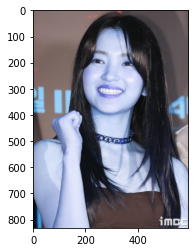

In [17]:
my_image_path = '/content/drive/MyDrive/다운로드.jfif'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

스머프 김태리다. 색상 바꿔주자

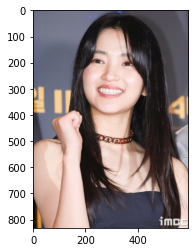

In [18]:
# 색상 바꾸기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

SVM으로 얼굴을 인식할 텐데 이를 잘 수행하기 위해서 HOG로 변환시켜주자.

In [19]:
# detector를 선언
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용하여 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb,1)

얼굴을 인식하기 위해서 초기 설정을 했지만, 전체 큰 영역에서 얼굴이라고 한 번에 인식하기란 어려움. 또한 얼굴 면적도 작기 때문에 이미지 피라미드를 이용할 것이다. 이를 사용하면, 작게 촬영된 얼굴을 크게 볼 수 있어 정확한 검출이 가능하다. 

rectangles[[(191, 142) (414, 365)]]


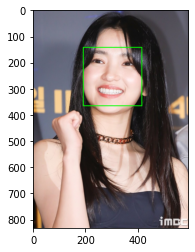

In [20]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [21]:
# 랜드마크 찾기

model_path = '/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있다. 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었다. 따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 된다. 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장된다.

landmark수가 68개로 잘 출력되고 있는 것을 확인할 수 있다.

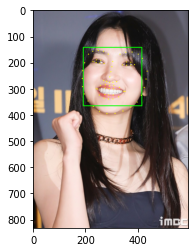

In [22]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [23]:
#  좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] + dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(292, 255)
(x,y) : (292,367)
(w,h) : (224,224)


얼굴 이미지에서 코의 중심점이 (292, 255)가 나온다.

원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문이다.


### Step 3. 스티커 적용 위치 확인하기

In [24]:
sticker_path = '/content/drive/MyDrive/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(224, 224, 3)


In [25]:
# 원본 이미지 좌표 조정

refined_x = x - w // 2
refined_y = y - h

# 음수 값 제거 (스티커의 시작점 + 스티커 사진이 원본 이미지 보다 클 경우)
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (180,143)


음수 값 안 나온다는 것을 확인했으니, 스티커를 사진에 적용해보자.

### Step 4 스티커 적용하기

In [26]:
# 스티커 사진에 적용, img_show[from:to] 형식입니다

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print("슝~")

슝~


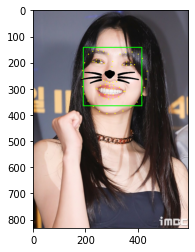

In [27]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

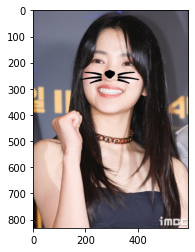

In [28]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 회고

처음에 스티커를 동물에게 적용시켜 보고 싶었다. 눈 코 입 변환만 잘 시켜준다면 좌표를 잘 잡을 수 있을 거라 생각했다. 하지만, 프로그램은 사람에게 맞춰져있어서 동물의 코를 사람의 코로 인식을 못하는 거 같았다. 강아지와, 고양이 등 다양하게 시도를 헀지만, 실패했다.

그래도 김태리로 프로젝트를 완성시킬 수 있어서 좋았다. 옆에서 개념설명과 실전까지 가르쳐주신 성보님께 감사를 표합니다.